In [ ]:
## Esta celda se ejecuta cuando el entorno es Google Colab. OJO: Ejecutar dos veces.

import os # Configura GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importar Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
## Esta celda se ejecuta en entorno local. OJO: No ejecutar en Google Colab.

import sionna

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Parametros del sistema
sionna.phy.config.seed = 81 # semilla para reproducibilidad
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 2 # bits por símbolo (QPSK)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo
CRC="CRC24A" # tipo de CRC

In [ ]:
class SinCodigCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.N])

        # Mapeo
        x = self.mapeador(b)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=coderate)
        no_c = tf.cast(no, tf.complex64)
        h_real = np.random.normal(0.0, np.sqrt(0.5), size=batch_size)
        h_imag = np.random.normal(0.0, np.sqrt(0.5), size=batch_size)
        h_plano = tf.convert_to_tensor(h_real + 1j * h_imag, dtype=tf.complex64)
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = self.awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = self.demapeador(x_eq, no_eff_broadcast)

        return b, llr

In [22]:
# Se inicializa el sistema con los bits congelados aleatorios
canal_rayleigh = SinCodigCanalRayleigh(N, bitsxsimb=bitsxsimb)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.1056e-01 | 1.0000e+00 |       21561 |      102400 |          100 |         100 |         0.0 |reached target block errors
      1.0 | 1.8791e-01 | 1.0000e+00 |       19242 |      102400 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 1.5656e-01 | 1.0000e+00 |       16032 |      102400 |          100 |         100 |         0.0 |reached target block errors
      3.0 | 1.4800e-01 | 1.0000e+00 |       15155 |      102400 |          100 |         100 |         0.0 |reached target block errors
      4.0 | 1.0944e-01 | 9.7000e-01 |       22414 |      204800 |          194 |         200 |         0.1 |reached target block errors
      5.0 | 1.1069e-01 | 9.4000e-01 |       22670 |      204800 |

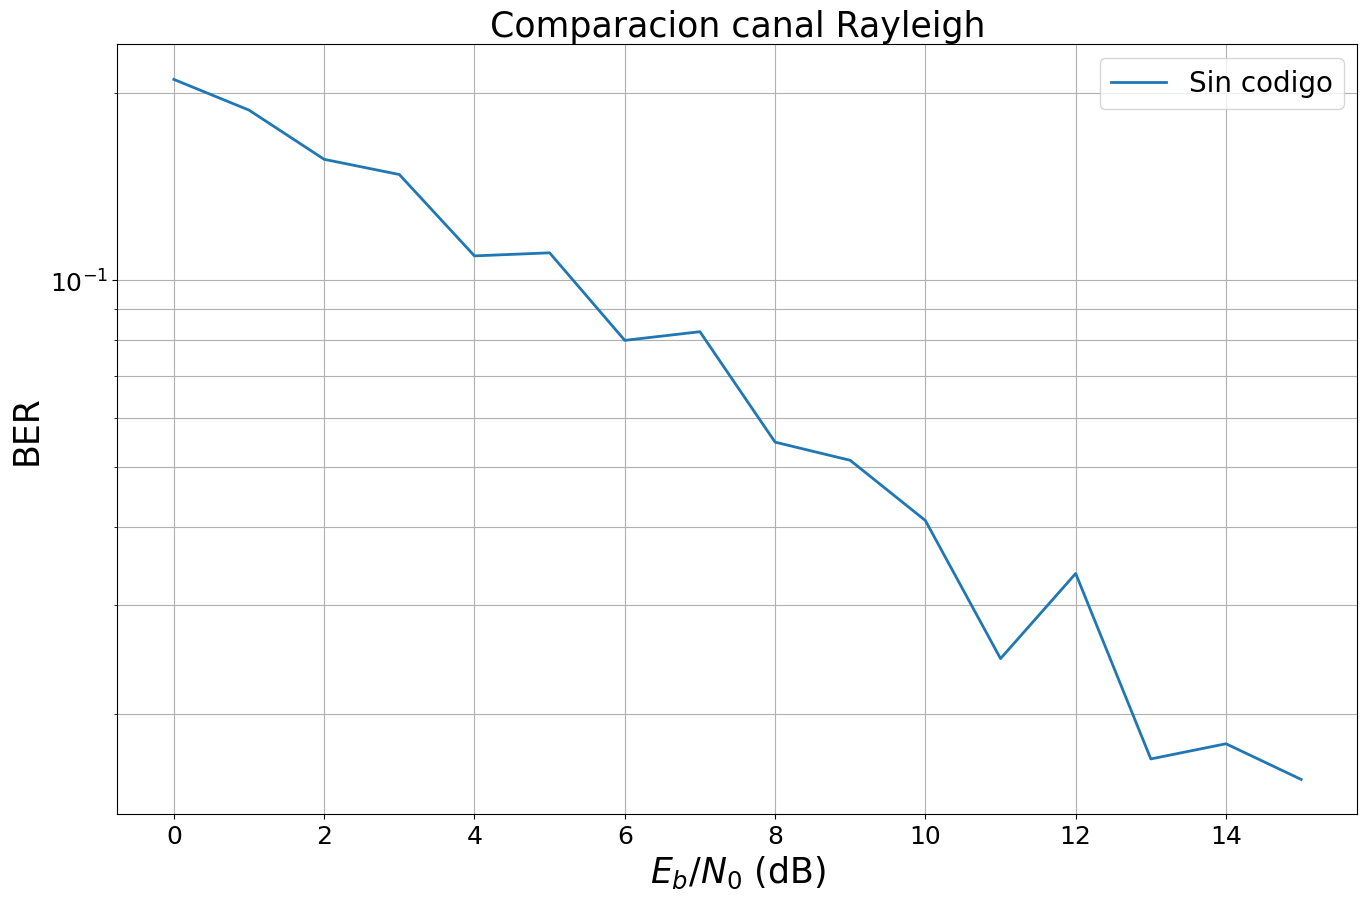

In [23]:
ber_plots = sionna.phy.utils.PlotBER("Comparacion canal Rayleigh")
ber_plots.simulate(canal_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [25]:
## Generador Monte Carlo de bits congelados para canal Rayleigh

# Parámetros del sistema
simulaciones = 200000
snr_prueba = 4.0 # Recomendacion paper Sun y Zhang
batch_size = 2000
num_batches = (simulaciones + batch_size - 1) // batch_size
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=coderate)
no_c = tf.cast(no, tf.complex64)

# Inicialización de bloques
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)
awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano

for i in range(N):
    # Se setean los bits congelados y reinicia conteo errores
    print(f"\rProcesando bit {i+1}/{N}", end="", flush=True)
    bits_congelados = np.array([j for j in range(N) if j != i])
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1)
    errores_totales = 0
    bits_totales = 0

    # Se generan simulaciones sobre el canal Rayleigh    
    for b in range(num_batches):
        bs = batch_size if (b < num_batches - 1) else (simulaciones - b*batch_size)
        bits = datos([bs, 1])
        bits_codif = codificador(bits)
        x = mapeador(bits_codif)

        # Canal Rayleigh plano + AWGN
        h_real = np.random.normal(0.0, np.sqrt(0.5), size=bs)
        h_imag = np.random.normal(0.0, np.sqrt(0.5), size=bs)
        h_plano = tf.convert_to_tensor(h_real + 1j * h_imag, dtype=tf.complex64)
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = demapeador(x_eq, no_eff_broadcast)
        bits_decodif = decodificador(llr)

        # Cálculo de errores
        err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
        errores_totales += int(err.numpy())
        bits_totales += bs  # porque bits es [bs,1] → 1 bit por muestra
        del bits, bits_codif, x, h_plano, y_pre, y, abs_h2_c, zf, x_eq, no_eff, no_eff_real, no_eff_broadcast, llr, bits_decodif

    BER_bits[i] = errores_totales / bits_totales

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]
print()

Procesando bit 1/1024

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


Procesando bit 1024/1024


In [26]:
# Sistema completo de codificación polar con canal Rayleigh
class CodPolarCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo=CRC, lista_SCL=8, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)
        
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)

        # Mapeo
        x = self.mapeador(bits_codif)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=coderate)
        no_c = tf.cast(no, tf.complex64)
        h_real = np.random.normal(0.0, np.sqrt(0.5), size=batch_size)
        h_imag = np.random.normal(0.0, np.sqrt(0.5), size=batch_size)
        h_plano = tf.convert_to_tensor(h_real + 1j * h_imag, dtype=tf.complex64)
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = self.awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = self.demapeador(x_eq, no_eff_broadcast)

        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)
        
        return b, b_hat, llr, crc_ok

In [27]:
# Se inicializa el sistema con los bits congelados obtenidos por Monte Carlo para canal Rayleigh
sistema_rayleigh = CodPolarCanalRayleigh(N, K, bits_congelados, bitsxsimb=bitsxsimb)

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.2870e-01 | 6.8750e-01 |      128325 |      390400 |          550 |         800 |        65.4 |reached target block errors
      1.0 | 2.9072e-01 | 6.2556e-01 |      127685 |      439200 |          563 |         900 |        71.8 |reached target block errors
      2.0 | 2.4001e-01 | 5.1200e-01 |      117123 |      488000 |          512 |        1000 |        74.8 |reached target block errors
      3.0 | 2.0492e-01 | 4.4417e-01 |      120004 |      585600 |          533 |        1200 |        99.6 |reached target block errors
      4.0 | 1.8605e-01 | 3.9538e-01 |      118030 |      634400 |          514 |        1300 |        97.5 |reached target block errors
      5.0 | 1.4108e-01 | 3.0412e-01 |      117040 |      829600 |

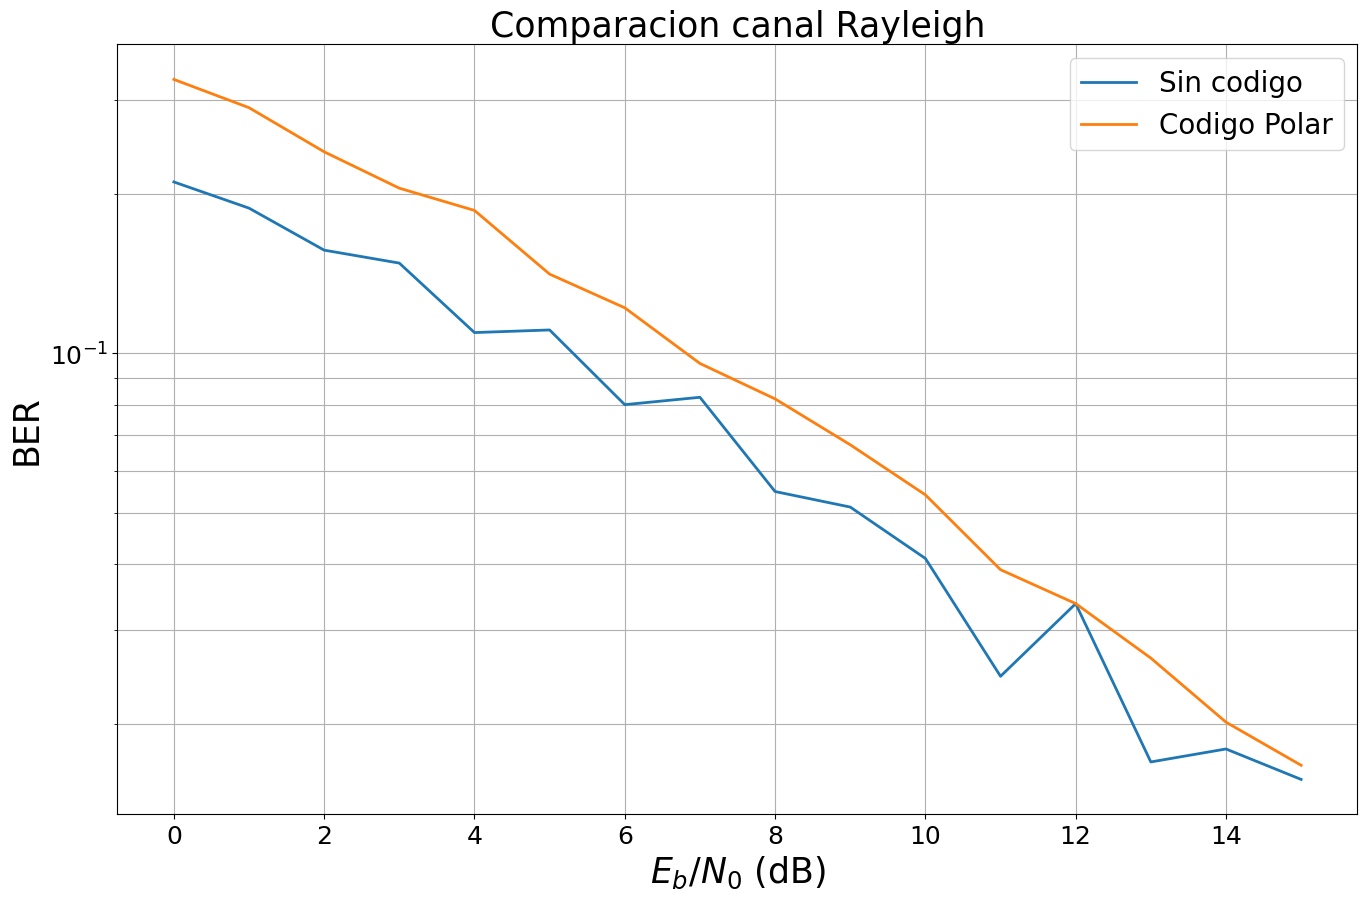

In [28]:
# Ploteo de la tasa de error para Rayleigh Polar
ber_plots.simulate(sistema_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);